## Goals
Our general goal is to analyze the startup world. We are interested in the general state of it, what industries are performing the best, which states look the most promising, and various other data. Additionally we also want to find some success qualifiers.


## Data preparation

In [4]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
investments = get_investments()
acquistions = get_acquisitions()
degrees = get_degrees()
funding_rounds = get_funding_rounds()
funds = get_funds()
ipos = get_ipos()
milestones = get_milestones()
objects = get_objects()
offices = get_offices()
people = get_people()
relationships = get_relationships()
companies = objects[objects["entity_type"] == "Company"]

Bellow snippet calculates a total percentage of missing values.

In [6]:
total_rows = 0
total_missing_rows = 0
total_attributes = 0
for dataset in [investments, acquistions, degrees, funding_rounds, funds, ipos, objects, offices, people, relationships]:
    missing_rows = dataset.isnull().sum().sum()  # nan rows
    total_rows += missing_rows + dataset.notnull().sum().sum()  # total rows
    total_missing_rows += missing_rows
    total_attributes += len(dataset.keys())

print(f"Total rows: {total_rows}")
print(f"Total attributes: {total_attributes}")
print(f"Percentage of missing values: ~{int((total_missing_rows / total_rows) * 100)}%")

Total rows: 28716673
Total attributes: 145
Percentage of missing values: ~32%


Distribution of startups by the state where they were founded.

<BarContainer object of 10 artists>

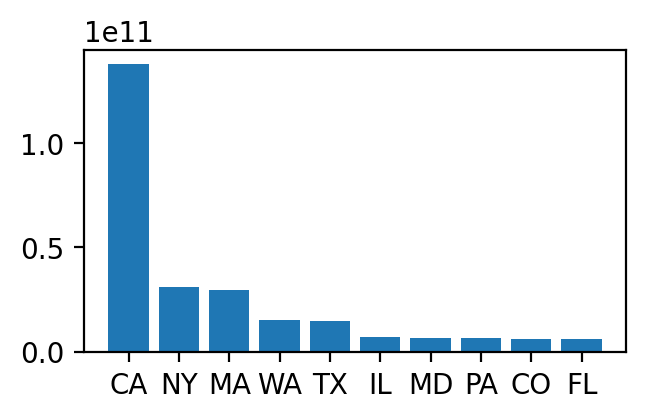

In [10]:
funding_per_state = companies.groupby("state_code")["funding_total_usd"].sum().sort_values(ascending=False).dropna()
fig, axes = plt.subplots(figsize=(3.5, 2), dpi=200)
axes.bar(funding_per_state[:10].index, funding_per_state[:10].values)

Graph of companies created over time. We can see that there was an explosion of new companies created in just the last few years.

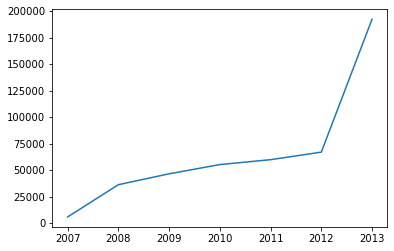

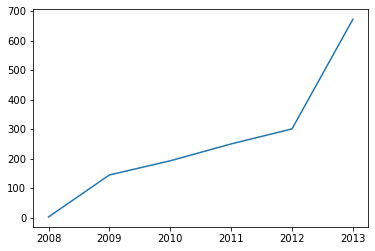

In [16]:
plot_year_count(objects, "created_at")
plt.figure()
plot_year_count(funds, "created_at")

It would be also interesting to see how was this growth connected to the amount of funding received from VCs.

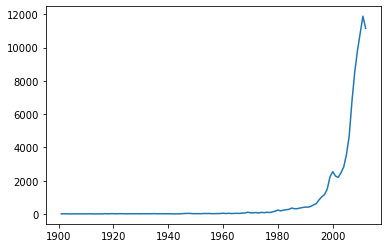

In [17]:
# show only date before 2013, due to a lot of missing values in the year 2013
plot_year_count(objects, "founded_at", "%Y-%m-%d", transform=lambda series: series[series[0] < 2013])

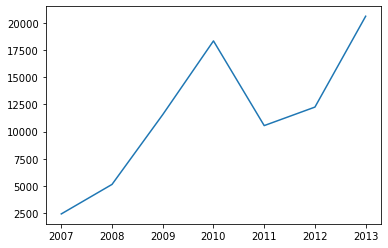

In [18]:
plot_year_count(investments, "created_at")

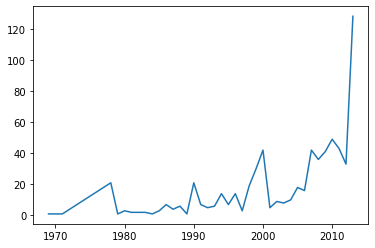

In [19]:
plot_year_count(ipos, "public_at", "%Y-%m-%d")

### 2. Industry sectors


<BarContainer object of 42 artists>

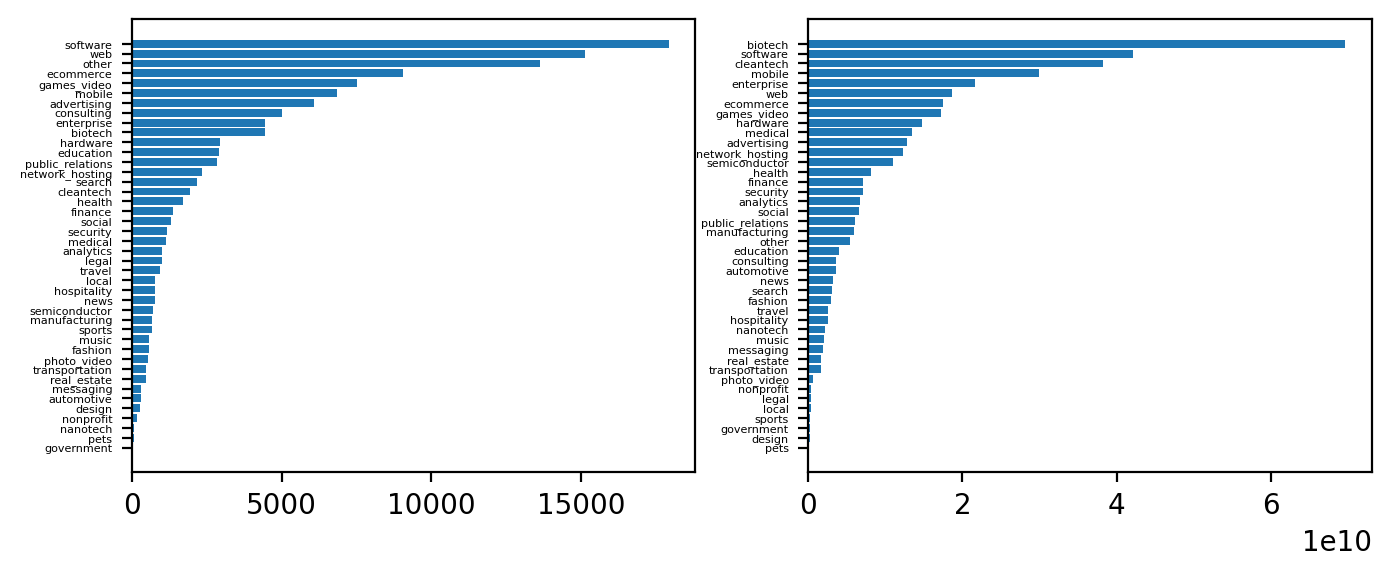

In [11]:
count_by_category = objects.groupby("category_code").size().sort_values()
total_fundings = funding_rounds.groupby("object_id", as_index=False)["raised_amount"].sum().sort_values("raised_amount",
                                                                                                        ascending=False)
total_fundings_per_category = total_fundings.merge(objects, left_on="object_id", right_on="id")[["category_code", "raised_amount"]].groupby("category_code").sum()["raised_amount"].sort_values()
total_fundings.merge(objects, left_on="object_id", right_on="id")[["category_code", "raised_amount"]].groupby(
    "category_code").sum()["raised_amount"].sort_values()

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
axes[0].tick_params(axis="y", labelsize=4)
axes[0].ticklabel_format(style='plain')
axes[0].barh(count_by_category.index, count_by_category.values)
axes[1].tick_params(axis="y", labelsize=4)
axes[1].barh(total_fundings_per_category.index, total_fundings_per_category.values)

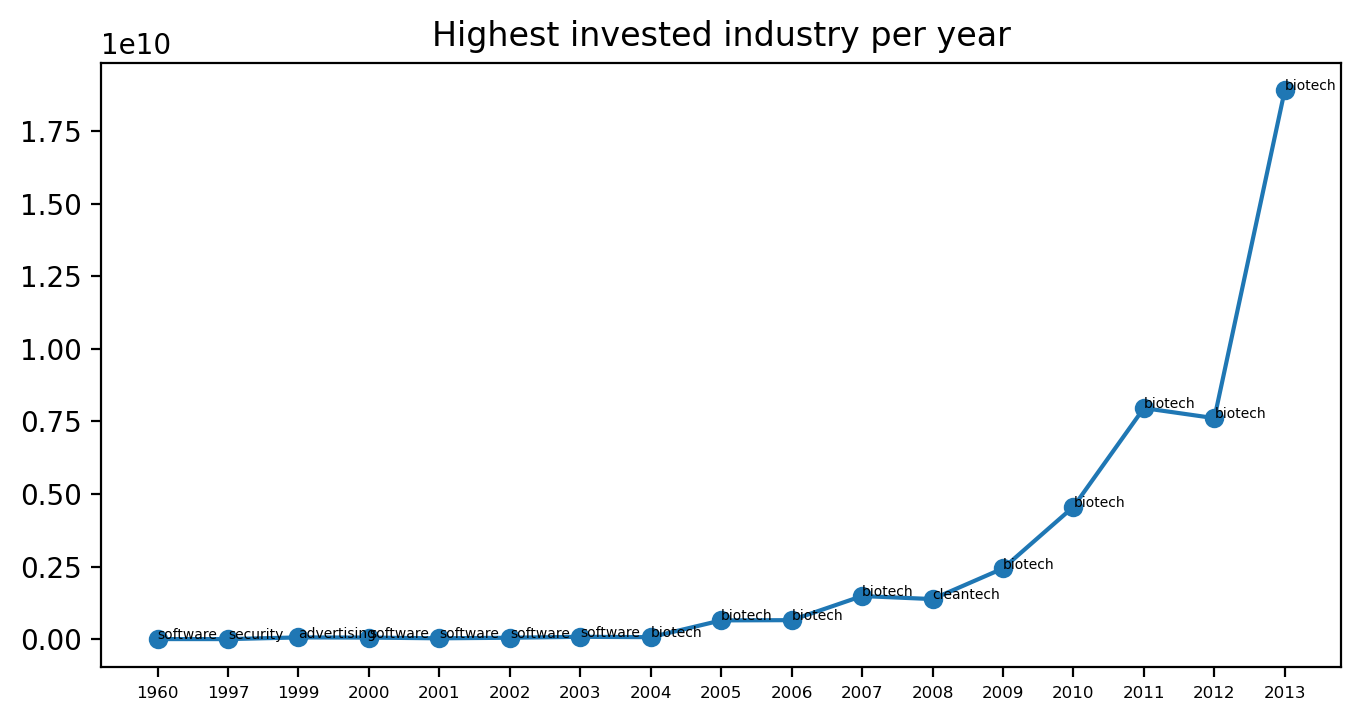

In [21]:
#Industrja z največjo investicijo vsako leto
from datetime import datetime
from matplotlib import pyplot

total_fundings_by_year = funding_rounds.copy()
total_fundings_by_year = total_fundings_by_year.dropna(axis=0)
total_fundings_by_year["funded_at"] = total_fundings_by_year["funded_at"].apply(
    lambda x: datetime.strptime(str(x), "%Y-%m-%d").year)
total_fundings_by_year = total_fundings_by_year.merge(objects, left_on="object_id", right_on="id")[
    ["category_code", "raised_amount", "funded_at"]].dropna()
max_fundings_in_year = total_fundings_by_year.groupby(["funded_at", "category_code"]).sum("raised_amount")
max_fundings_in_year = max_fundings_in_year.reset_index().loc[
    max_fundings_in_year.reset_index().groupby("funded_at")["raised_amount"].idxmax()]

fig, axes = pyplot.subplots(figsize=(8, 4), dpi=200)
axes.tick_params(axis="x", labelsize=6)
axes.set_title("Highest invested industry per year")
line = axes.plot(max_fundings_in_year["funded_at"].apply(lambda x: str(x)), max_fundings_in_year["raised_amount"],
                 marker='o')
line[0].get_xdata(orig=False)
for row in zip(max_fundings_in_year["category_code"], line[0].get_xdata(orig=False), line[0].get_ydata(orig=False)):
    axes.annotate(row[0], (row[1], row[2]), size=5)

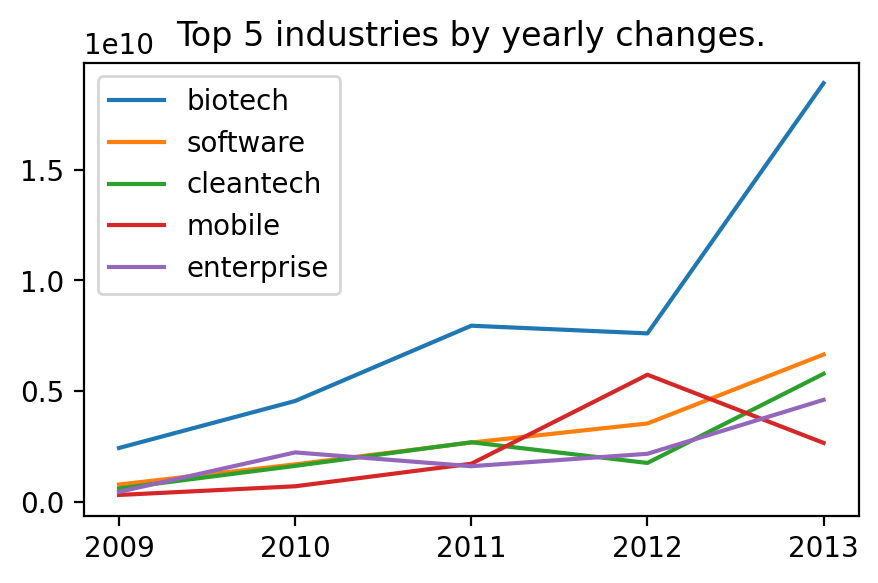

In [14]:
def get_category_yearly_investments(cat):
    total_fundings_by_year = funding_rounds.copy()
    total_fundings_by_year = total_fundings_by_year.dropna(axis=0)
    total_fundings_by_year["funded_at"] = total_fundings_by_year["funded_at"].apply(lambda x:datetime.strptime(str(x), "%Y-%m-%d").year)
    total_fundings_by_year = total_fundings_by_year.merge(companies, left_on="object_id", right_on="id")[["category_code", "raised_amount", "funded_at"]].dropna()
    grouped = total_fundings_by_year.groupby(["category_code", "funded_at"]).sum("raised_amount")
    grouped = grouped.reset_index()[grouped.reset_index()["category_code"] == cat]
    return grouped

means = pd.DataFrame(columns=["category_code", "mean"])
for cat in pd.unique(companies["category_code"].dropna()):
    pct = get_category_yearly_investments(cat).iloc[-5:]["raised_amount"].mean()
    df = pd.DataFrame({"category_code":cat, "mean":pct}, index=[0])
    means = pd.concat([means, df])

fig, axes = plt.subplots(figsize=(4, 3), dpi=200)
for _, mean in means.sort_values("mean", ascending=False).reset_index()[:5].iterrows():
    pct = get_category_yearly_investments(mean[1])[-5:]
    axes.plot(pct["funded_at"].apply(lambda x:str(x)), pct["raised_amount"], label=mean[1])
axes.set_title("Top 5 industries by yearly changes.")
axes.legend()

### 3. Companies

Where did employees enquire their education ?

In [9]:
people_relationships = pd.merge(people, relationships, left_on='object_id', right_on='person_object_id')
people_relationships_companies = pd.merge(people_relationships, objects, left_on="relationship_object_id", right_on='id')
people_relationships_degrees = pd.merge(people_relationships, degrees, left_on='object_id', right_on='object_id')

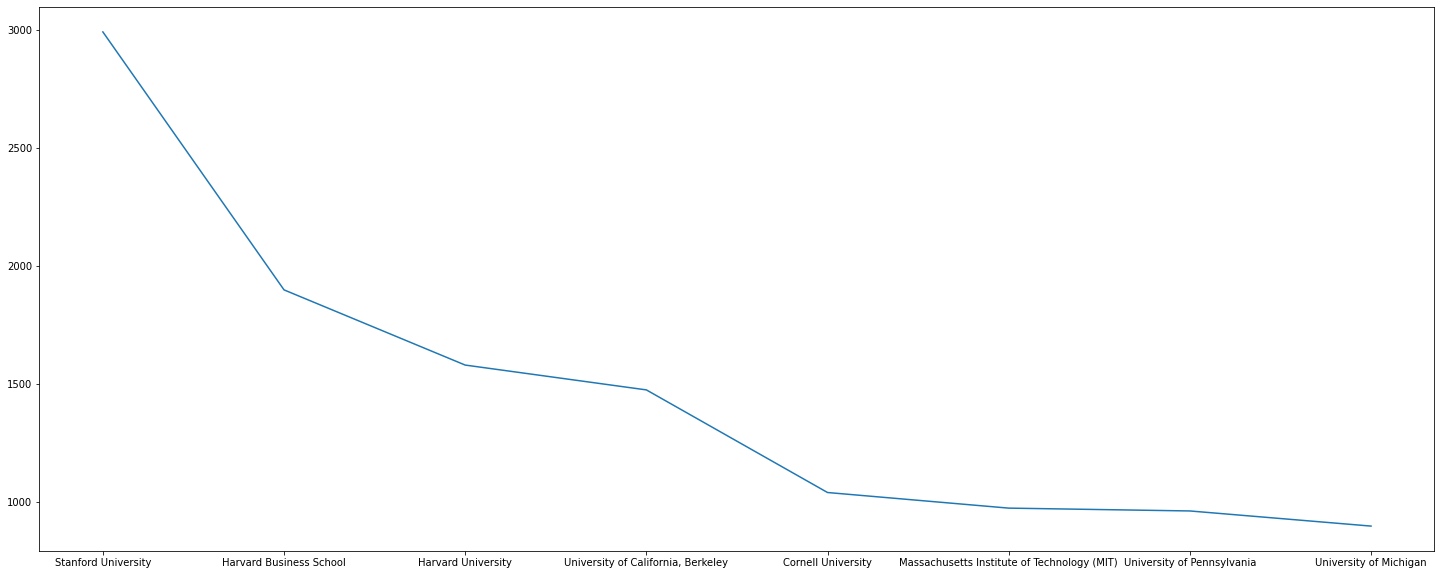

In [18]:
colleges = degrees.groupby('institution').apply(lambda x: x.shape[0]).sort_values(ascending=False)
plt.figure(figsize=(25,10))
plt.plot(colleges.head(8))

In [71]:
percentage_not_graduated = degrees["graduated_at"].isnull().sum() / degrees["graduated_at"].shape[0]
print(f"Percentage of employees that didn't graduate: ~{int(percentage_not_graduated * 100)}%")

Percentage of employees that didn't graduate: ~47%
